## Import statements

In [1]:
import ypp
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
# import pandas as pd
# import time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
import pathlib
import sep

## Functions

In [2]:
def gaussian_x(x, height, center, width, bgoffset):
#Returns a gaussian function with the given parameters
    width = float(width)
    return (height*np.exp(-((((x - center)/width)**2)/ 2.))) + bgoffset

In [3]:
def gauss_compare(dr, sl, g_dex):
    plt.plot(dr, sl[g_dex])
    plt.plot(dr, [gaussian_x(f, gaussian_fits[g_dex][0], gaussian_fits[g_dex][1], gaussian_fits[g_dex][2], gaussian_fits[g_dex][3]) for f in dr])

### Specify data path

In [4]:
datapath = '../Methods Paper/'

### Display files in path

In [5]:
files = glob.glob(datapath + '*.fit*')
files = [os.path.basename(path) for path in files]
print(files)

['bkg_f0015.fits', 'f0009_trans.fits', 'bkg_f0009_trans.fits', 'f0015.fits', 'f0005.fits']


### Print name of current file

In [6]:
filename = 'f0009_trans.fits'
extensionless_name = filename[:filename.find('.')]
pathlib.Path(os.path.join(datapath, extensionless_name)).mkdir(exist_ok=True)
pathlib.Path(os.path.join(datapath, extensionless_name, 'data_tables')).mkdir(exist_ok=True)
print('filename =',filename)

filename = f0009_trans.fits


### Display bit range of current file

In [7]:
currentfile = datapath + filename
fits.info(currentfile)
hdul = fits.open(currentfile)
original_image_data = hdul[0].data
wcs = WCS(hdul[0])
if hdul[0].header['NAXIS'] == 3:
    print("COLOR IMAGE")
    original_image_data = original_image_data[0]
bits = hdul[0].header['BITPIX']

Filename: ../Methods Paper/f0009_trans.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     316   (3841, 3835)   int16 (rescales to uint16)   


### Display file image

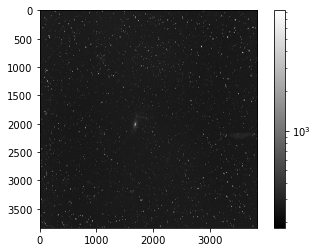

In [8]:
from ypp.utils.plot import plot_plate

image_data = np.array(np.copy(original_image_data))
plot_plate(image_data)

### Convert to positive

In [9]:
from ypp.preprocessing.crop import invert

negative = False
if negative:
    image_data = invert(image_data)
    plot_plate(image_data)

### Crop image

In [10]:
from ypp.preprocessing.crop import crop_ndarray

crop_check = False
if crop_check:
    center = (2000, 2000)
    radius = (500, 500)
    image_data = crop_ndarray(image_data, center, radius)
    plot_plate(image_data)

### Get plate specs

In [11]:
plate_median = np.median(image_data)
plate_width = len(image_data)

### Extract plate objects

In [12]:
from ypp.matching.sextract import sextract_world_locs
coords = sextract_world_locs(image_data, 3., wcs)

### Query star catalogs

In [13]:
from ypp.matching.query import get_plate_bounds

ra_bounds, dec_bounds = get_plate_bounds(image_data, wcs)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [14]:
from ypp.matching.query import SDSS_query

result = SDSS_query(ra_bounds, dec_bounds)
print(len(result))

19201


In [15]:
catalog = SkyCoord(result["ra"], result["dec"], unit=u.deg)
idx, d2d, d3d = coords.match_to_catalog_sky(catalog)

In [16]:
print(len(idx))

9221


### Match plate objects to catalog

In [17]:
sources = result[idx]
sources["plate_ra"] = coords.ra
sources["plate_dec"] = coords.dec
sources["plate_sep"] = d2d

### Aperture photometry

In [ ]:
radius_unit = plate_width / plate_width_wcs
aperture_radius = 0.004 * radius_unit
buffer_radius = 0.006 * radius_unit
background_radius = 0.008 * radius_unit
aperture_area = (np.pi * (aperture_radius ** 2))
buffer_area = (np.pi * (buffer_radius ** 2))
background_area = (np.pi * (background_radius ** 2)) - buffer_area
constant = 22.5
print("Aperture radius: ", aperture_radius)
print("Buffer radius: ", buffer_radius)
print("Background radius: ", background_radius)

aperture_list, aperture_list_err, aperture_list_flag = sep.sum_circle(data_sub, objects['x'], objects['y'], aperture_radius, err=bkg.globalrms, gain=1.0)
background_list, background_list_err, background_list_flag = sep.sum_circann(data_sub, objects['x'], objects['y'], buffer_radius, background_radius, err=bkg.globalrms, gain=1.0)
background_densities = [annulus_sum / background_area for annulus_sum in background_list]
fluxes = np.array([aperture_list[i] - (aperture_area * background_densities[i]) for i in range(len(aperture_list))])
nan_mask = fluxes < 0
calculated_mags = constant - 2.5*np.log10(fluxes)

In [ ]:
if gaia_check:
    master_table = star_info_gaia[fast_matches]
if SDSS_check:
    master_table = star_info_SDSS[fast_matches]
master_table['flux'] = fluxes
master_table['calculated_mags'] = calculated_mags
master_table['plate_ra'] = object_coords[:, 0]
master_table['plate_dec'] = object_coords[:, 1]
master_table['plate_x'] = objects['x']
master_table['plate_y'] = objects['y']
master_table.remove_rows(np.arange(0, len(nan_mask))[nan_mask])
clean_mask = master_table['clean'] == 0
master_table.remove_rows(np.arange(0, len(clean_mask))[clean_mask])
print(len(master_table))

In [ ]:
master_table['umg'] = master_table['u'] - master_table['g']
master_table['gmp'] = master_table['g'] - master_table['calculated_mags']
#SDSS_corrected = [SDSS_mags_g[i] * (0.2 * (SDSS_mags_u[i] - SDSS_mags_g[i])) for i in range(len(SDSS_mags_g))]

master_table.write(datapath + '/data_tables/' + extensionless_name + '_matched.csv', format='csv', overwrite=True)

In [ ]:
plt.title(extensionless_name.split('_')[0] + r' ($\sigma = $' + str(sigma) + ")")
plt.hist(master_table['g'], bins='auto')
plt.savefig(datapath + '/' + extensionless_name + '_hist.png')

In [ ]:
plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('log10(flux)')
plt.gca().set_xlabel('SDSS g magnitudes')
plt.scatter(master_table['g'], master_table['calculated_mags'], c='red')

In [ ]:
plt.figure(figsize=(11.5, 11.5))
plt.gca().set_ylabel('u - g')
plt.gca().set_xlabel('g - plate')
# plt.xlim(0.75, 2)
plt.ylim(7, 10)
# plt.gca().set_ylabel('u - g')
# plt.gca().set_xlabel('g - plate')
plt.scatter(master_table['umg'], master_table['gmp'])

In [ ]:
def color_correction(x):
    h1 = 0.9
    k1 = 8.7
    h2 = 2.
    k2 = 8.1
    slope = (k2 - k1) / (h2 - h1)
    return (slope*(h1 - x)) + k1

master_table['color_correction'] = color_correction(np.array(master_table['g']))
master_table['corrected_mags'] = master_table['color_correction'] + master_table['calculated_mags']

plt.figure(figsize=(11.5, 11.5))
# plt.ylim(5.3, 6.4)
# plt.xlim(14.9, 18)
plt.gca().invert_yaxis()
plt.gca().set_ylabel('SDSS g magnitudes')
plt.gca().set_xlabel('log10(flux)')
plt.scatter(master_table['corrected_mags'], master_table['g'], c='red')

In [ ]:
import scipy.stats
slope_cal, intercept_cal, r_value, p_value, std_err = scipy.stats.linregress(master_table['corrected_mags'], master_table['g'])
print(std_err)
def calibrate_mag(x):
    return (slope_cal * x) + intercept_cal

In [ ]:
# 1: 167.86885, 28.77947
# 2: 167.59673, 28.73918
# 3: 167.68761, 28.61742

three_coords = [(167.86876, 28.77950), (167.68729, 28.61764), (167.59663, 28.73876)]
three_ids = star_info_SDSS['objid'][quick_match(three_coords, star_info_SDSS_coords, 0.1, 0.5)]
three_mags = np.array([master_table['corrected_mags'][np.where(master_table['objid'] == i)][0] for i in three_ids])
# for three_id in three_ids:
#     objid_found = 0
#     for i in range(len(master_table)):
#         if master_table['objid'][i] == three_id:
#             three_mags.append(master_table['g'][i])
#             objid_found = 1
#     if not objid_found:
#         three_mags.append(-1)
print(three_mags)
print(calibrate_mag(three_mags))

### Gaussian fitting

In [ ]:
domain_half = 20
d_range = range(0 - domain_half, domain_half)
slices = []
gaussian_fits = []
for i in range(len(star_cm_locations)):
    if((star_x_cm_location[i] < (len(image_data[0]) - domain_half)) and (star_x_cm_location[i] > domain_half)):
        star_slice = image_data[int(star_y_cm_location[i])][int(star_x_cm_location[i] - domain_half) : int(star_x_cm_location[i] + domain_half)]
        slices.append(star_slice)
        params, params_cov = opt.curve_fit(gaussian_x, d_range, star_slice, [10000, 0, 1, plate_median])
        gaussian_fits.append(params)
gaussian_fits = np.asarray(gaussian_fits)

### CSV writing

In [ ]:
table_len = len(cleaned_gaia_mags)
preprocessing_table = Table()
# preprocessing_table['plate_median'] = np.full(table_len, plate_median)
# preprocessing_table['plate_width'] = np.full(table_len, plate_width)
# preprocessing_table['plate_width_wcs'] = np.full(table_len, plate_width_wcs)
# preprocessing_table['g_amplitude'] = gaussian_fits[:, 0]
# preprocessing_table['g_width'] = gaussian_fits[:, 2]
# preprocessing_table['g_background'] = gaussian_fits[:, 3]
preprocessing_tablele['gaia_flux'] = star_fluxes
preprocessing_table['gaia_mag'] = star_info_SDSS['g']
# preprocessing_table['SDSS_flux'] = star_fluxes
# preprocessing_table['SDSS_mag'] = star_info_SDSS['g']

preprocessing_table.write(datapath + '/data_tables/' + extensionless_name + '.csv', format='csv', overwrite=True)